# Imports

In [2]:
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm 


# 1. EDA

### Cargar dataset

In [3]:
df = pd.read_csv('../data/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Dataset Size

In [4]:
df.shape

(101766, 50)

Dataset Types

In [5]:
# los tipos de dato de cada columna
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [6]:
# change ID columns to object types
df['encounter_id'] = df['encounter_id'].astype('object')
df['patient_nbr'] = df['patient_nbr'].astype('object')
df['admission_type_id'] = df['admission_type_id'].astype('object')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('object')
df['admission_source_id'] = df['admission_source_id'].astype('object')




In [7]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [8]:
def estudio_dataset(df, exclude_columns=None):
    resultados = {}
    exclude_columns = exclude_columns or []

    for col in df.columns:
        if col in exclude_columns:
            continue

        if pd.api.types.is_numeric_dtype(df[col]):
            # Estudio para columnas numéricas
            resumen = df[col].describe()
            missing = df[col].isnull().sum()
            resumen_dict = resumen.to_dict()
            resumen_dict['missing'] = missing
            resultados[col] = {
                'tipo': 'numérica',
                'estudio': resumen_dict
            }
        else:
            # Estudio para columnas categóricas
            missing = df[col].isnull().sum()
            unique_values = df[col].dropna().unique().tolist()
            porcentajes = df[col].value_counts(normalize=True, dropna=True) * 100
            resultados[col] = {
                'tipo': 'categórica',
                'unique_values': unique_values,
                'porcentajes': porcentajes.to_dict(),
                'missing': missing
            }
    return resultados



In [22]:
dataset_dict = estudio_dataset(df, exclude_columns=['encounter_id', 'patient_nbr'])

dataset_dict['age']

{'tipo': 'categórica',
 'unique_values': ['[0-10)',
  '[10-20)',
  '[20-30)',
  '[30-40)',
  '[40-50)',
  '[50-60)',
  '[60-70)',
  '[70-80)',
  '[80-90)',
  '[90-100)'],
 'porcentajes': {'[70-80)': 25.615628009354797,
  '[60-70)': 22.092840437867263,
  '[50-60)': 16.956547373386,
  '[80-90)': 16.898571232042137,
  '[40-50)': 9.516930998565336,
  '[30-40)': 3.709490399544052,
  '[90-100)': 2.744531572430871,
  '[20-30)': 1.6282451899455614,
  '[10-20)': 0.6790087062476662,
  '[0-10)': 0.15820608061631586},
 'missing': 0}

## UNIVARIATE ANALYSIS

In [9]:
MISSING_VALUES = {'?': None}
df = df.replace(MISSING_VALUES)

In [9]:

def univariate_analysis_grid(df, save_dir=None, exclude_columns=['encounter_id', 'patient_nbr']):

    df = df.drop(columns=exclude_columns, errors='ignore')

    num_cols = len(df.columns)
    cols_per_row = 3
    rows = math.ceil(num_cols / cols_per_row)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)  # Crear directorio si no existe

    # Ajustar tamaño de la figura
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 5))
    axes = axes.flatten()  # Convertimos en un array 1D para iterar fácilmente

    sns.set_palette("pastel")  # Configurar la paleta de colores

    # Barra de progreso
    print("Procesando columnas...")
    for i, col in enumerate(tqdm(df.columns, desc="Analizando")):
        ax = axes[i]  # Seleccionar el subplot correspondiente
        
        if pd.api.types.is_numeric_dtype(df[col]):
            # Histograma para variables numéricas
            sns.histplot(df[col], kde=True, ax=ax)
            ax.set_title(f'Histograma de {col}')
        else:
            # Gráfico de barras para variables categóricas
            sns.countplot(x=df[col], ax=ax)
            ax.set_title(f'Conteo de {col}')
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)  # Rotar etiquetas de forma segura

        # Guardar la imagen individual si se especificó un directorio
        if save_dir:
            file_path = os.path.join(save_dir, f"{col}.png")
            fig_individual, ax_individual = plt.subplots(figsize=(6, 4))
            if pd.api.types.is_numeric_dtype(df[col]):
                sns.histplot(df[col], kde=True, ax=ax_individual)
            else:
                sns.countplot(x=df[col], ax=ax_individual)
                plt.setp(ax_individual.xaxis.get_majorticklabels(), rotation=90)
            ax_individual.set_title(ax.get_title())
            plt.savefig(file_path, bbox_inches='tight')
            plt.close(fig_individual)  # Cerrar la figura individual para liberar memoria

    # Eliminar cualquier subplot vacío si hay menos columnas que espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    print("Análisis completado 🚀")


Procesando columnas...


Analizando: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


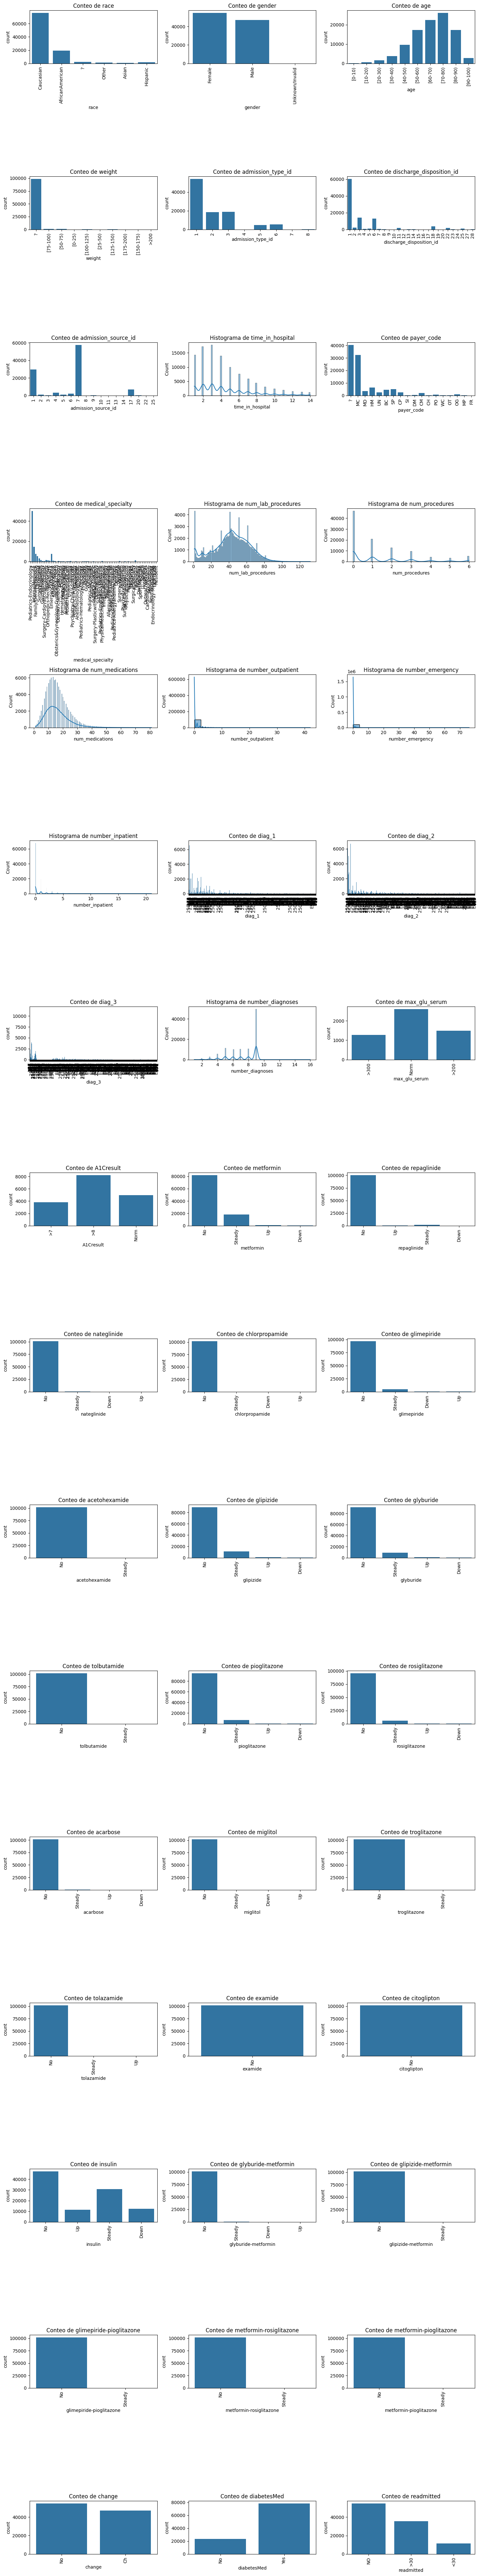

Análisis completado 🚀


In [10]:
univariate_analysis_grid(df, save_dir='../docs/EDA_PLOTS/univariate_analysis', exclude_columns=['encounter_id', 'patient_nbr'])

# Bivariate analysis


In [17]:
def analisis_numerico(df, save_dir=None):
    """
    Genera un análisis bivariante (pairplot) de las columnas numéricas de un DataFrame.
    
    Parámetros:
      - df: DataFrame de pandas.
      - save_dir: Ruta donde se guardará la imagen del pairplot (opcional).
    """
    # Seleccionar únicamente las columnas numéricas
    columnas_numericas = df.select_dtypes(include=['number']).columns
    if len(columnas_numericas) < 2:
        print("El DataFrame debe tener al menos dos columnas numéricas para realizar un análisis bivariante.")
        return

    # Configurar la paleta pastel
    sns.set_palette("pastel")
    
    # Crear el pairplot (se puede ajustar el tamaño de cada subgráfico con 'height')
    pair_plot = sns.pairplot(df[columnas_numericas], height=3)
    
    # Ajustar los ángulos de las etiquetas de cada eje
    for ax in pair_plot.axes.flatten():
        ax.tick_params(axis='x', rotation=0)
        ax.tick_params(axis='y', rotation=90)
    
    # Ajustar título y layout
    pair_plot.fig.suptitle("Análisis Bivariante", y=1.02)
    pair_plot.fig.tight_layout()

    # Guardar la imagen si se especifica save_dir
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        file_path = os.path.join(save_dir, "bivariate_analysis.png")
        pair_plot.savefig(file_path, bbox_inches='tight')
    
    plt.show()


def matriz_correlacion(df, save_dir=None):
    """
    Genera una matriz de correlación para las columnas numéricas de un DataFrame
    y la muestra en forma de heatmap usando seaborn con paleta pastel.
    
    Parámetros:
      - df: DataFrame de pandas.
      - save_dir: Ruta donde se guardará la imagen del heatmap (opcional).
    """
    # Seleccionar solo columnas numéricas
    df_numerico = df.select_dtypes(include=['number'])
    if df_numerico.shape[1] < 2:
        print("El DataFrame debe tener al menos dos columnas numéricas para calcular la correlación.")
        return

    # Calcular la matriz de correlación
    corr_matrix = df_numerico.corr()

    # Configurar la paleta pastel
    sns.set_palette("pastel")
    plt.figure(figsize=(8, 6))
    
    # Crear el heatmap de la matriz de correlación
    ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Pastel1")
    plt.title("Matriz de Correlación")
    plt.tight_layout()

    # Guardar la imagen si se especifica save_dir
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        file_path = os.path.join(save_dir, "correlation_matrix.png")
        plt.savefig(file_path, bbox_inches='tight')

    plt.show()


def analisis_categorico(df,excluir=None):

    # Seleccionar columnas categóricas
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Excluir las columnas indicadas (si las hay)
    if excluir is not None:
        columnas_categoricas = [col for col in columnas_categoricas if col not in excluir]
    
    if len(columnas_categoricas) < 2:
        print("El DataFrame debe tener al menos dos columnas categóricas (después de excluir) para realizar un análisis bivariante.")
        return
    
    # Generar los pares de columnas y sus respectivas tablas de contingencia
    pares = []
    for i in range(len(columnas_categoricas)):
        for j in range(i+1, len(columnas_categoricas)):
            col1 = columnas_categoricas[i]
            col2 = columnas_categoricas[j]
            print(f"Analizando relación entre '{col1}' y '{col2}'")
            
            # Copiar y reemplazar los valores nulos por '?'
            df_temp = df[[col1, col2]].copy()
            df_temp[col1] = df_temp[col1].fillna("?")
            df_temp[col2] = df_temp[col2].fillna("?")
            
            # Generar la tabla de contingencia
            tabla_contingencia = pd.crosstab(df_temp[col1], df_temp[col2], dropna=False)
            if tabla_contingencia.empty:
                print(f"La tabla de contingencia para {col1} y {col2} está vacía.")
                continue
            
            pares.append((col1, col2, tabla_contingencia))
    
    # Agrupar y mostrar los heatmaps de 2 en 2
    por_figura = 2
    for idx in range(0, len(pares), por_figura):
        grupo = pares[idx:idx+por_figura]
        ncols = len(grupo)
        fig, axes = plt.subplots(1, ncols, figsize=(6 * ncols, 5))
        if ncols == 1:
            axes = [axes]
        for ax, (col1, col2, tabla_contingencia) in zip(axes, grupo):
            sns.set_palette("pastel")
            sns.heatmap(tabla_contingencia, annot=True, fmt="d", cmap="Pastel1", ax=ax)
            ax.set_title(f"Tabla de contingencia: {col1} vs {col2}")
            ax.set_xlabel(col2)
            ax.set_ylabel(col1)
        plt.tight_layout()
        plt.show()

def analisis_target(df, target, excluir=None, save_dir=None):
    """
    Genera un análisis bivariante para columnas categóricas, mostrando para cada par una 
    tabla de contingencia en forma de heatmap utilizando seaborn con paleta pastel.

    Parámetros:
      - df: DataFrame de pandas.
      - target: Variable objetivo a analizar.
      - excluir: Lista de columnas a excluir del análisis (opcional).
      - save_dir: Ruta donde se guardarán los gráficos (opcional).
    """

    # Seleccionar columnas categóricas
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Excluir las columnas indicadas (si las hay)
    if excluir is not None:
        columnas_categoricas = [col for col in columnas_categoricas if col not in excluir]

    # Crear el directorio de guardado si se especifica
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Inicializar lista de pares
    pares = []

    # Barra de progreso para analizar cada columna categórica
    for col in tqdm(columnas_categoricas, desc="Generando heatmaps"):

        # Copiar y reemplazar valores nulos por '?'
        df_temp = df[[col, target]].copy()
        df_temp[col] = df_temp[col].fillna("?")
        df_temp[target] = df_temp[target].fillna("?")

        # Generar la tabla de contingencia
        tabla_contingencia = pd.crosstab(df_temp[col], df_temp[target], dropna=False)
        if tabla_contingencia.empty:
            continue

        pares.append((col, target, tabla_contingencia))

    # Agrupar y mostrar los heatmaps de 2 en 2
    por_figura = 2
    for idx in range(0, len(pares), por_figura):
        grupo = pares[idx:idx + por_figura]
        ncols = len(grupo)
        fig, axes = plt.subplots(1, ncols, figsize=(6 * ncols, 5))
        
        # Asegurar que `axes` sea iterable incluso con 1 solo gráfico
        if ncols == 1:
            axes = [axes]

        for ax, (col1, col2, tabla_contingencia) in zip(axes, grupo):
            sns.set_palette("pastel")
            sns.heatmap(tabla_contingencia, annot=True, fmt="d", cmap="Pastel1", ax=ax)
            ax.set_title(f"Tabla de contingencia: {col1} vs {col2}")
            ax.set_xlabel(col2)
            ax.set_ylabel(col1)

            # Guardar la imagen si `save_dir` está definido
            if save_dir:
                file_path = os.path.join(save_dir, f"heatmap_{col1}_vs_{col2}.png")
                fig_individual, ax_individual = plt.subplots(figsize=(6, 5))
                sns.heatmap(tabla_contingencia, annot=True, fmt="d", cmap="Pastel1", ax=ax_individual)
                ax_individual.set_title(f"Tabla de contingencia: {col1} vs {col2}")
                ax_individual.set_xlabel(col2)
                ax_individual.set_ylabel(col1)
                plt.savefig(file_path, bbox_inches='tight')
                plt.close(fig_individual)  # Cerrar la figura individual para liberar memoria

        plt.tight_layout()
        plt.show()

    print("Análisis completado 🚀")

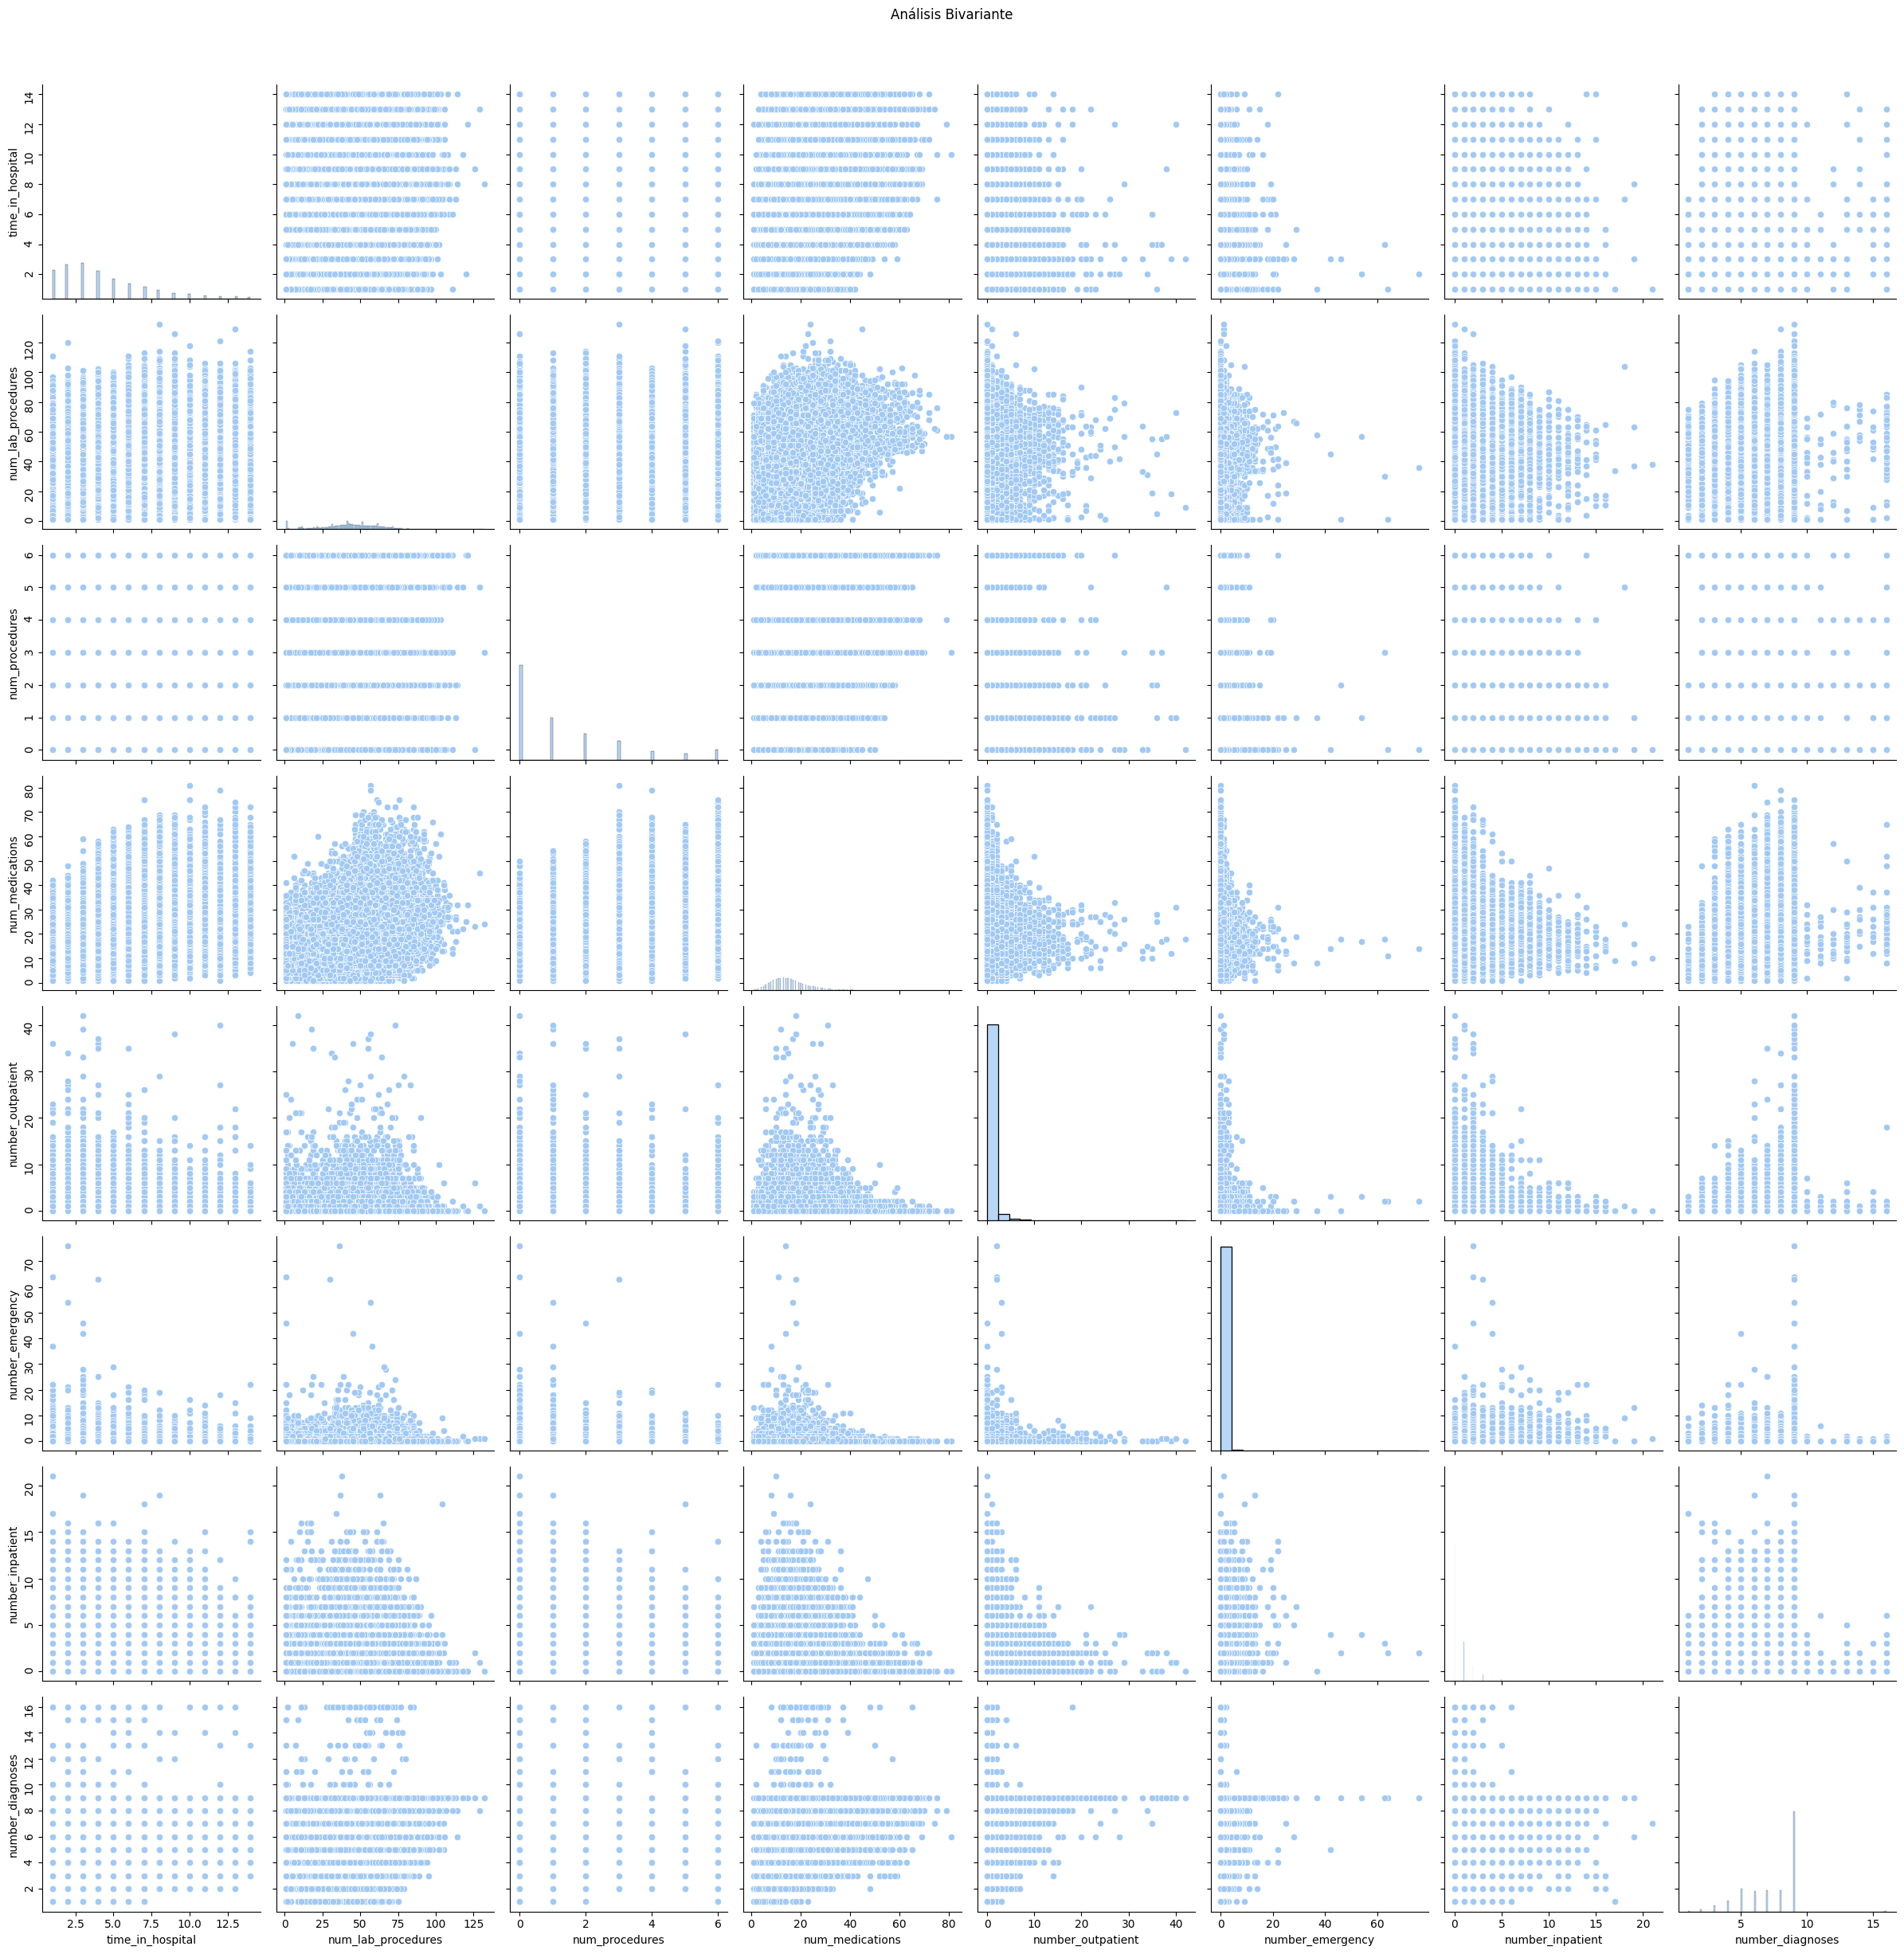

In [13]:
analisis_numerico(df, save_dir='../docs/EDA_PLOTS/Bivariate_analysis/Numeric')

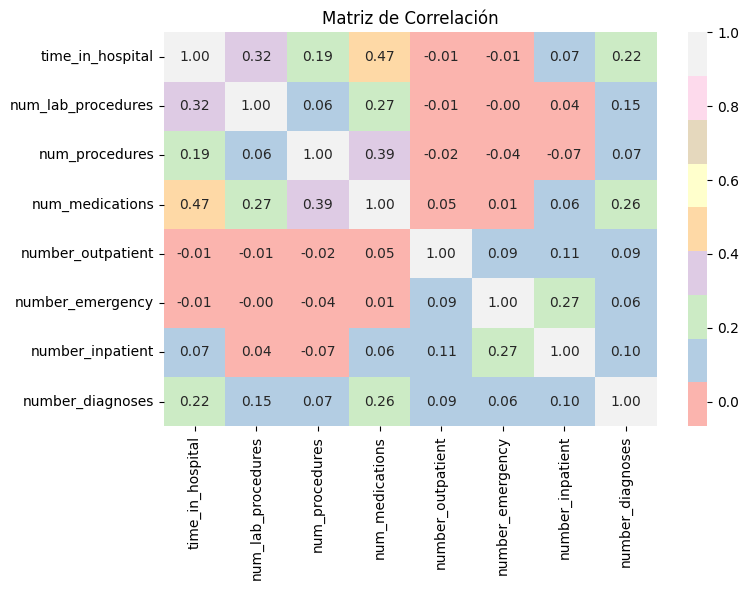

In [14]:
matriz_correlacion(df, save_dir='../docs/EDA_PLOTS/Bivariate_analysis/Numeric')

In [15]:
# analisis_categorico(df, excluir=['encounter_id', 'patient_nbr'])

Generando heatmaps:   8%|▊         | 3/39 [00:00<00:03, 10.63it/s]C:\Users\lukag\AppData\Local\Temp\ipykernel_20552\2521042913.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp[col] = df_temp[col].fillna("?")
Generando heatmaps:  13%|█▎        | 5/39 [00:00<00:03, 10.70it/s]C:\Users\lukag\AppData\Local\Temp\ipykernel_20552\2521042913.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp[col] = df_temp[col].fillna("?")
C:\Users\lukag\AppData\Local\Temp\ipykernel_20552\2521042913.py:157: FutureWarning: Downcasting object dtype arrays on

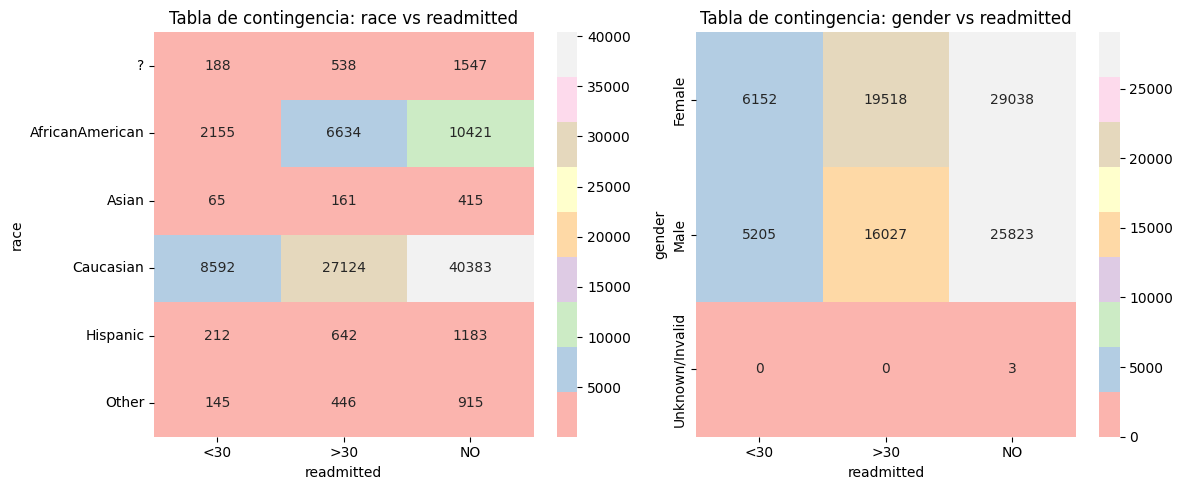

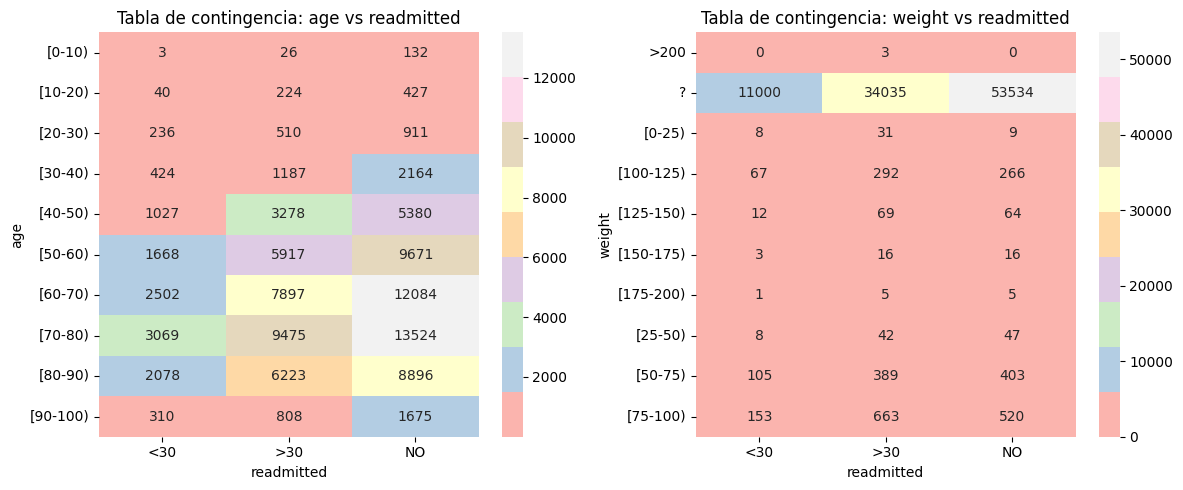

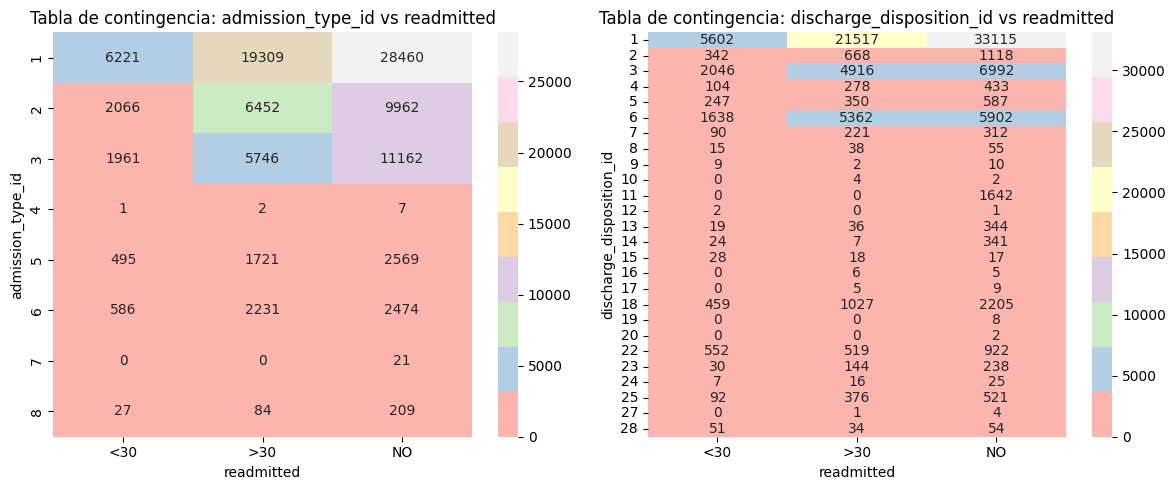

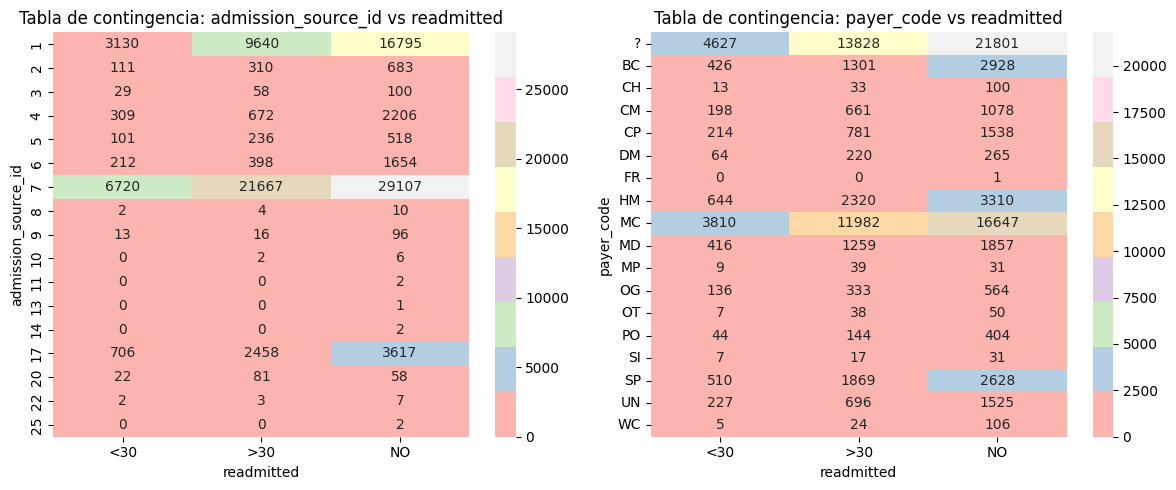

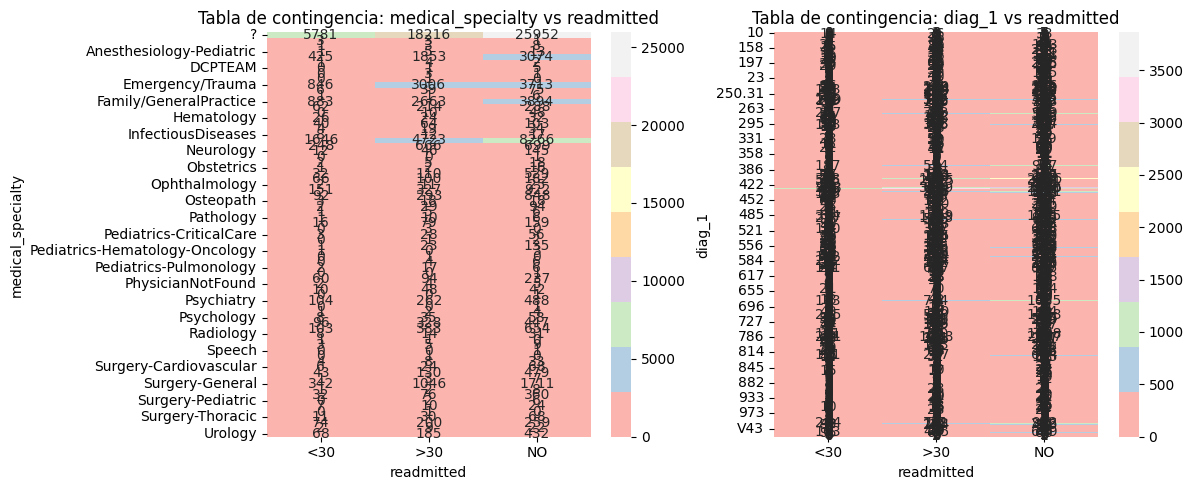

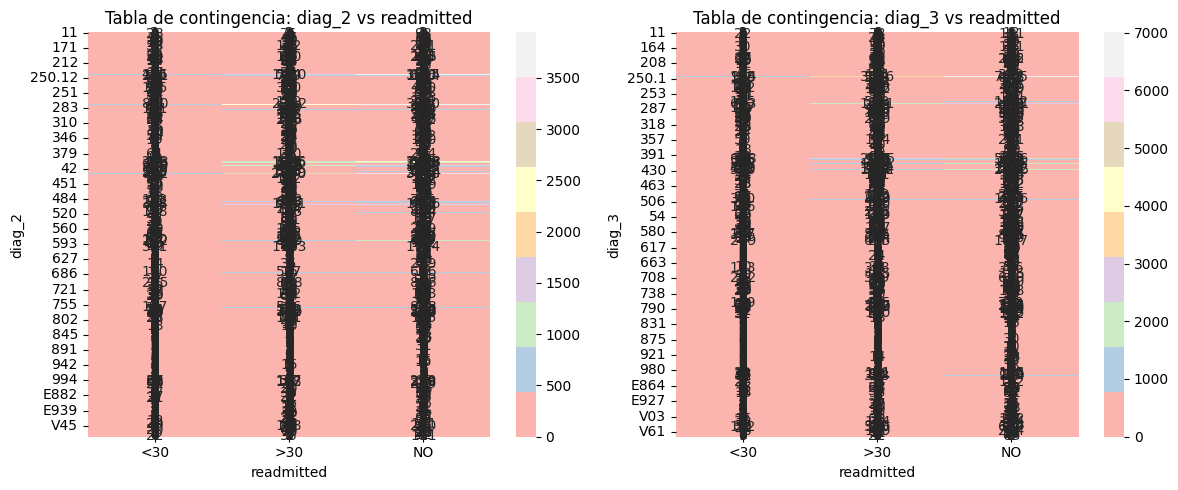

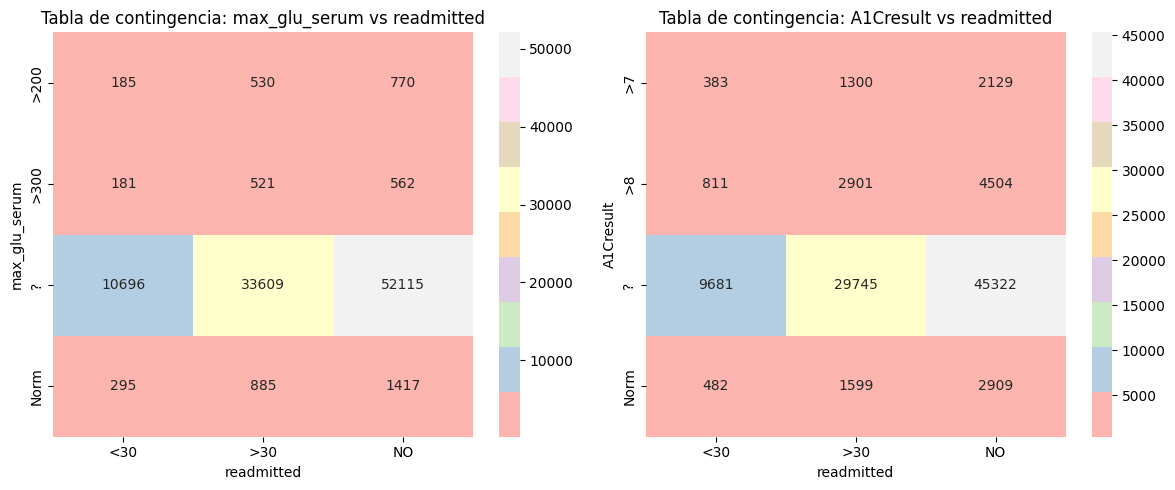

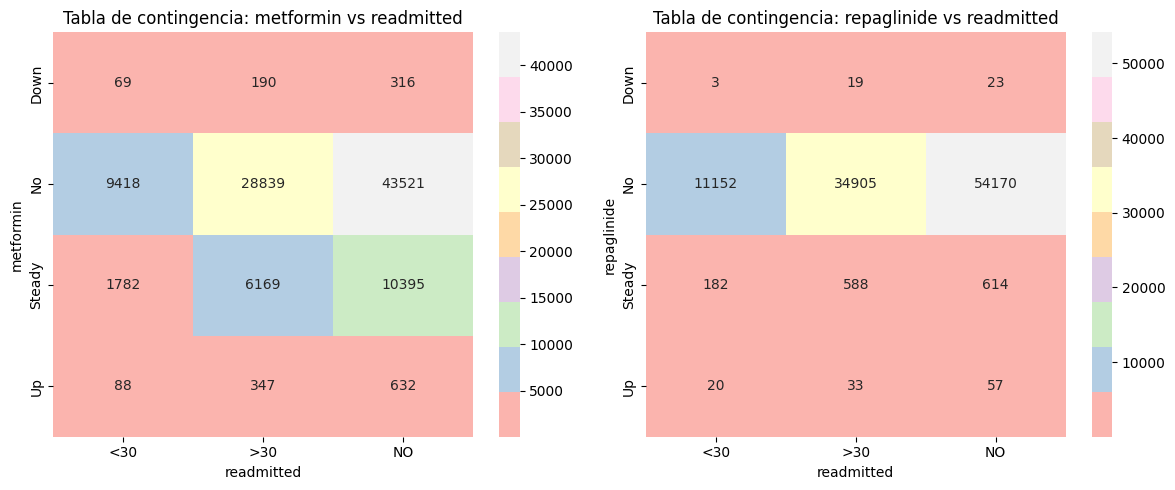

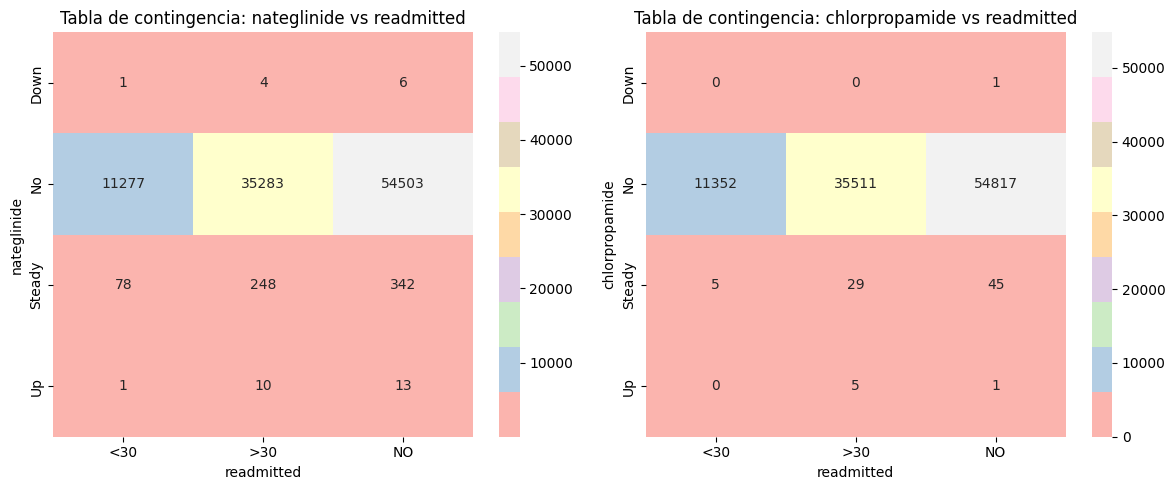

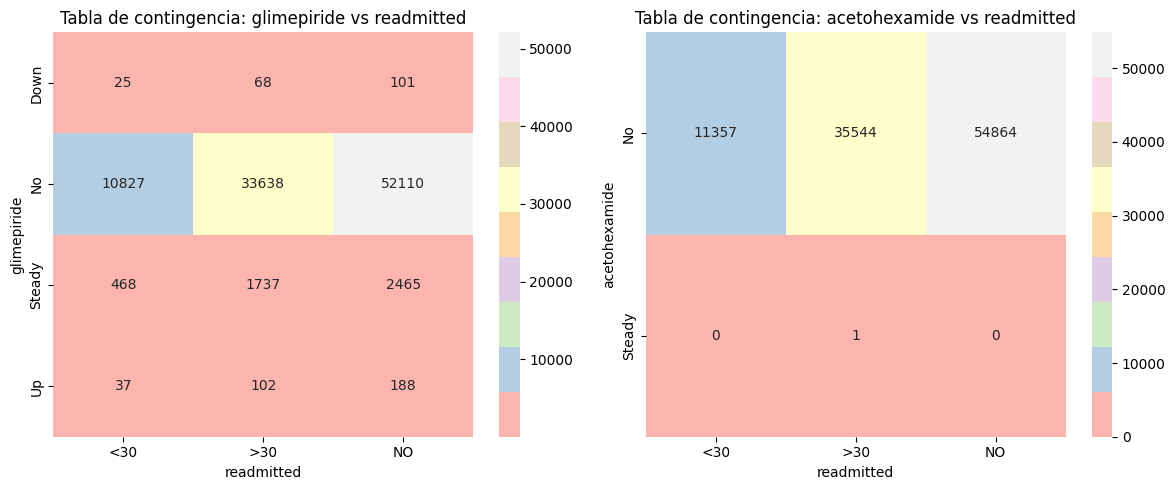

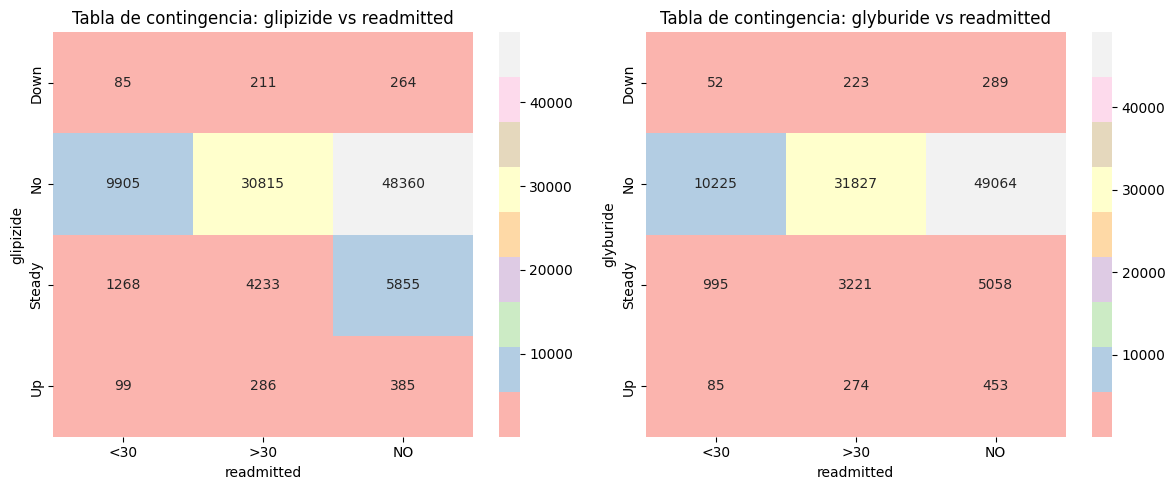

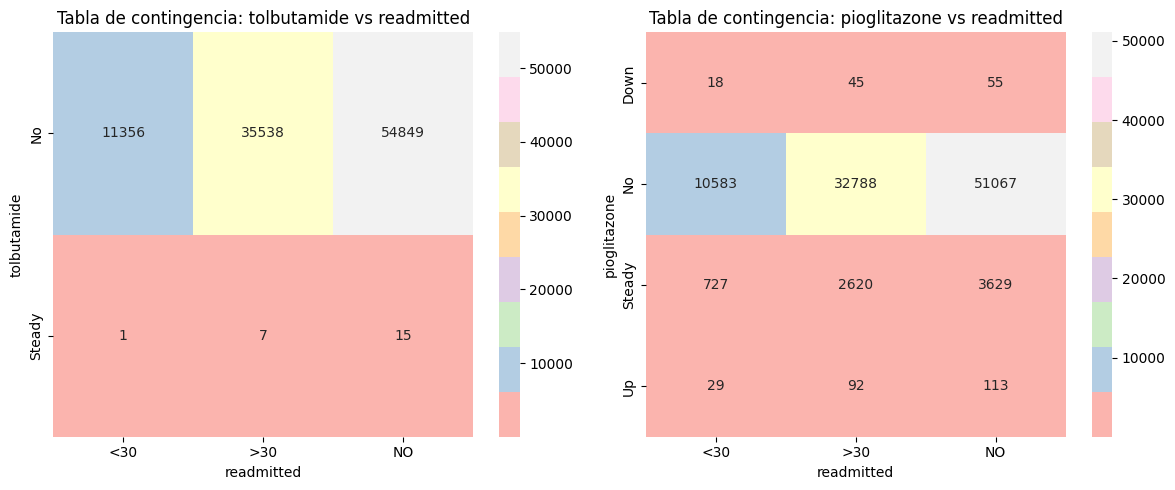

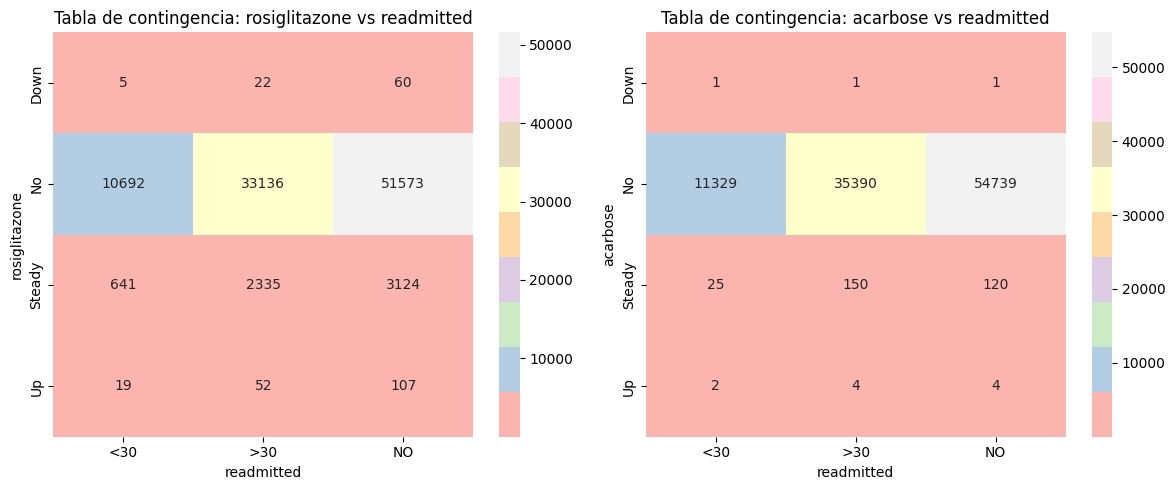

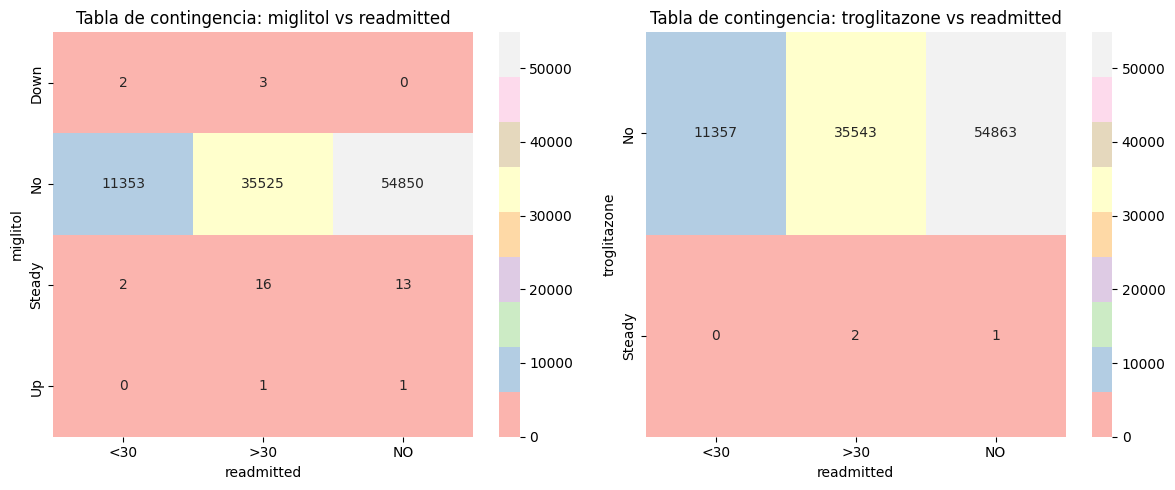

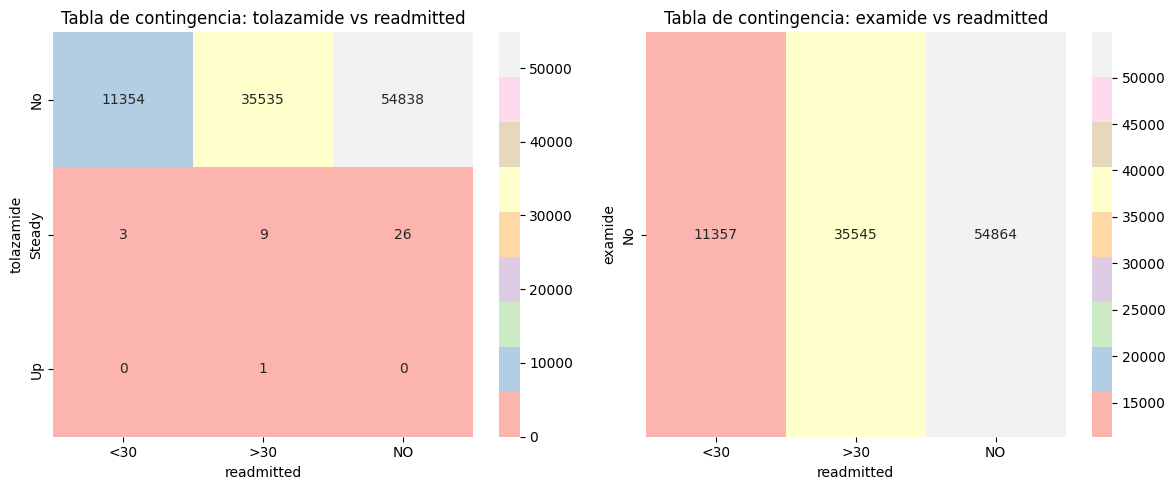

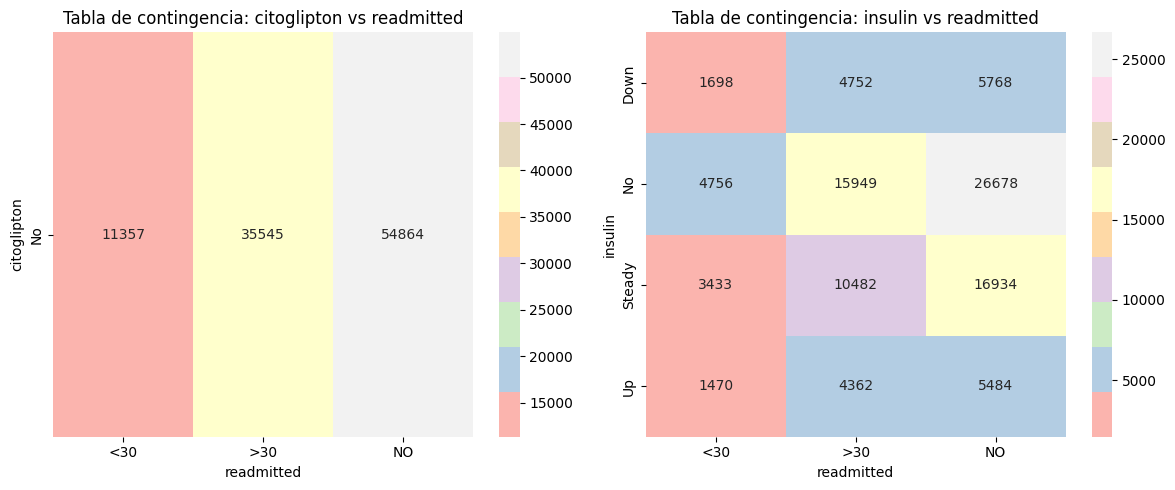

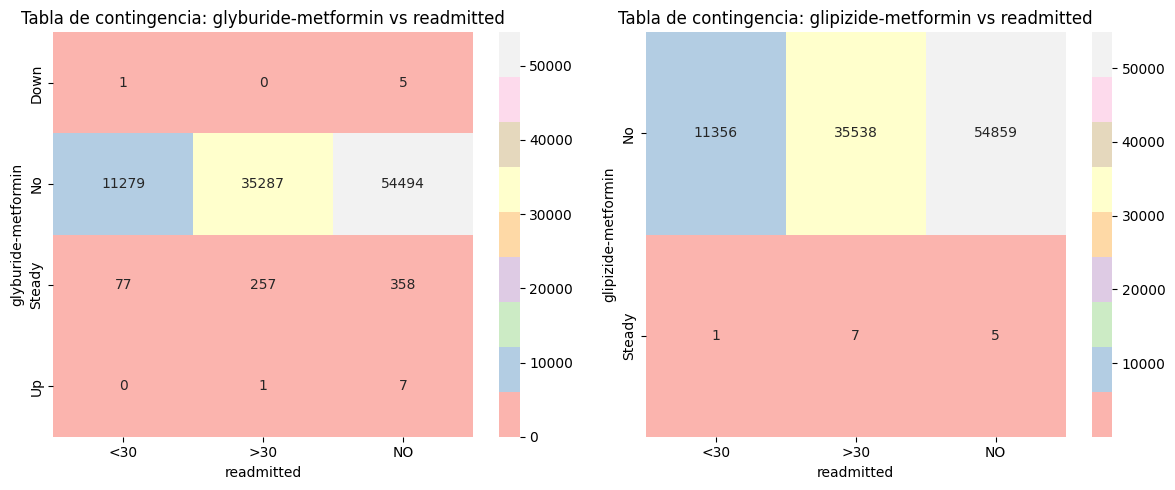

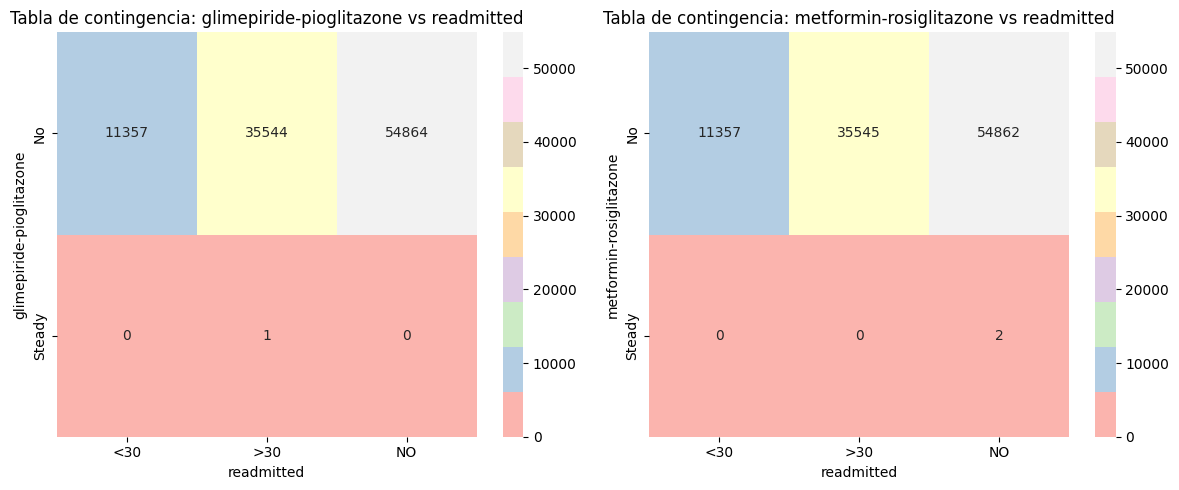

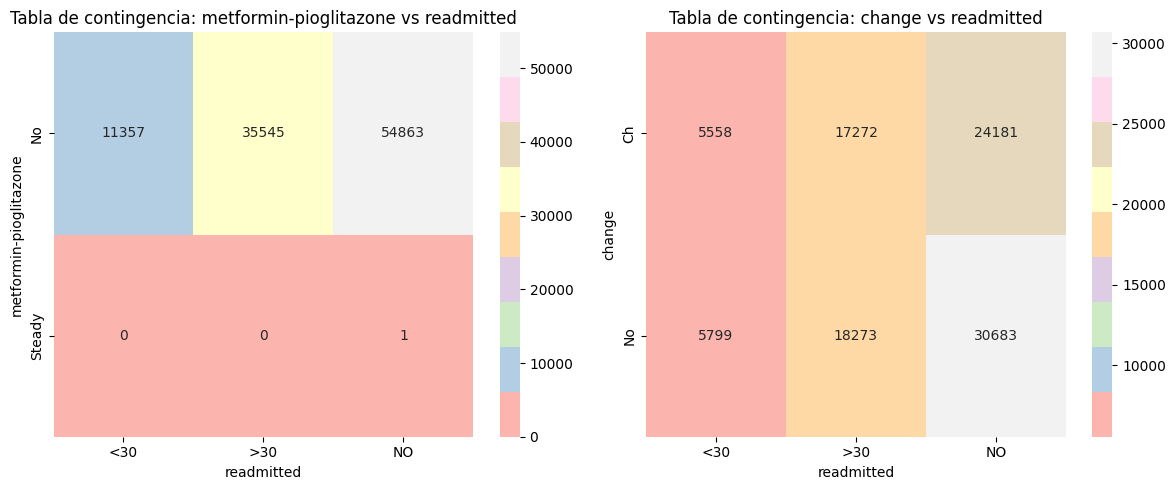

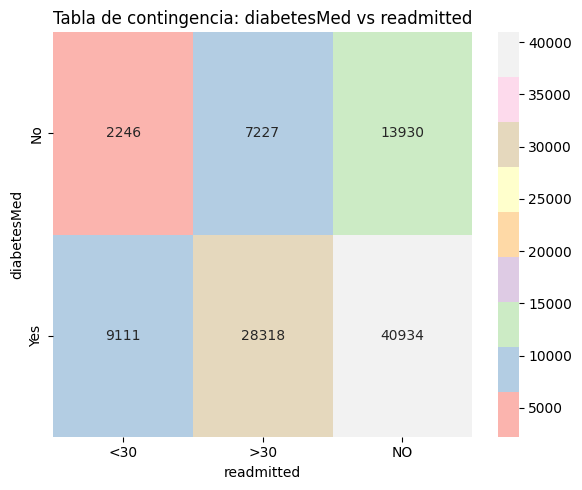

Análisis completado 🚀


In [18]:
analisis_target(df, 'readmitted',excluir=['encounter_id', 'patient_nbr','readmitted'], save_dir='../docs/EDA_PLOTS/Bivariate_analysis/Categorical')

In [19]:
def top_classes_by_readmission(df, study_columns, target, top_x):

    for col in study_columns:
        print(f"\nAnálisis para la columna: {col}")
        for readm in df[target].unique():
            counts = df[df[target] == readm][col].value_counts().head(top_x)
            print(f"\nReadmission: {readm}")
            print(counts)
        print("\n" + "-" * 50 + "\n")


In [20]:
# Ejemplo de uso:
independent_study_columns = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']
top_x = 5  # O el valor que desees
top_classes_by_readmission(df, independent_study_columns, 'readmitted', top_x)





Análisis para la columna: medical_specialty

Readmission: NO
medical_specialty
InternalMedicine          8266
Family/GeneralPractice    3894
Emergency/Trauma          3713
Cardiology                3074
Surgery-General           1711
Name: count, dtype: int64

Readmission: >30
medical_specialty
InternalMedicine          4723
Emergency/Trauma          3006
Family/GeneralPractice    2663
Cardiology                1853
Surgery-General           1046
Name: count, dtype: int64

Readmission: <30
medical_specialty
InternalMedicine          1646
Family/GeneralPractice     883
Emergency/Trauma           846
Cardiology                 425
Surgery-General            342
Name: count, dtype: int64

--------------------------------------------------


Análisis para la columna: diag_1

Readmission: NO
diag_1
414    3861
428    2805
786    2307
410    2176
486    1825
Name: count, dtype: int64

Readmission: >30
diag_1
428    3089
414    2125
786    1418
486    1369
491    1073
Name: count, dtype: int